In [101]:
import sys
sys.path.append("..")
import os
from utils.load_data import load_parquet, load_index, load_csv
from utils.evaultation.generator import Generator
from algo.LSHAlgo import LSH
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import ndcg_score, dcg_score
import math

In [2]:
# x = load_csv(os.path.abspath("../data/airline_reviews/raw_data/airline_reviews.csv"))
# pd.set_option('display.max_colwidth', None)
# pd.DataFrame(x, columns=['ReviewHeader']).head()

In [82]:
ground_truth_path = os.path.abspath('../data/eval/gt/starbucks_vsm__type=gt.parquet')
ground_truth = load_parquet(ground_truth_path)
print(f"Number of queries: {ground_truth.shape[0]}")
print(f"Top K: {len(ground_truth['top_k'][0].tolist())}")
ground_truth.head()

Number of queries: 32
Top K: 31


,question,top_k,time_taken
0,Have been frequenting Starbucks for 30 years. ...,[Have been frequenting Starbucks for 30 years....,291
1,Second time in a week I've gone to Starbucks a...,[Second time in a week I've gone to Starbucks ...,433
2,"I visited the Starbucks, Greensboro, NC Sept ...","[I visited the Starbucks, Greensboro, NC Sept...",587
3,This time this girl named KP was taking my ord...,[This time this girl named KP was taking my or...,530
4,"DEMANDED TIPS FROM ME, THEN MADE ME WAIT UNTIL...","[DEMANDED TIPS FROM ME, THEN MADE ME WAIT UNTI...",314


In [3]:
top_k = 10
runners = []
nbits_config = [2, 4, 8, 16, 32, 64, 128, 256, 512, 768]
for nbits in nbits_config:
    runners.append(lambda nbits=nbits: LSH("starbucks", "bge", nbits))
questions = ground_truth["question"].tolist()


In [40]:
# k + 1 to account for query maybe inside the returned documents
generator = Generator(questions, top_k+1)
generator.run(runners)

|████████████████████████████████████████| 320/320 [100%] in 6:04.8 (0.88/s) 


In [15]:
def remove_query_from_predictions(documents, query):
    if query in documents:
        index = documents.index(query)
        documents.pop(index)
    else:
        documents.pop()
    return documents

### Mean Precision@K

In [64]:
output_folder_path = os.path.abspath('../data/eval/2024-09-14_00-50-34')
num_questions = ground_truth.shape[0]

In [54]:
def get_mean_precision_k(k, num_relevant_docs):
    mean_precision_scores = []
    for nbits in nbits_config:
        df = load_parquet(os.path.join(output_folder_path, f"starbucks_lsh__embedding=bge_mode=lsh_similarity_nbits={nbits}.parquet"))
        precision_score = 0
        for i in range(num_questions):
            question = ground_truth["question"][i]
            set1 = set(ground_truth["top_k"][i][1:num_relevant_docs+1])
            set2 = set(remove_query_from_predictions(list(json.loads(df["top_k"][i])["Review"].values()), question)[0:k])
            true_positive = len(set1.intersection(set2))
            precision_score += true_positive/k
        mean_precision_scores.append(precision_score/num_questions)
    return mean_precision_scores

Mean Precision@3

In [65]:
mean_precision_score_at_3 = get_mean_precision_k(3,10)
mean_precision_score_at_5 = get_mean_precision_k(5,10)
mean_precision_score_at_10 = get_mean_precision_k(10,10)

In [66]:
df = pd.DataFrame({
    'nbits_config': nbits_config,
    'Mean Average Precision@3': mean_precision_score_at_3,
    'Mean Average Precision@5': mean_precision_score_at_5,
    'Mean Average Precision@10': mean_precision_score_at_10
})
df

,nbits_config,Mean Average Precision@3,Mean Average Precision@5,Mean Average Precision@10
0,2,0.020833,0.02500,0.015625
1,4,0.031250,0.02500,0.021875
2,8,0.020833,0.01875,0.015625
3,16,0.041667,0.03125,0.034375
4,32,0.041667,0.04375,0.031250
5,64,0.135417,0.10625,0.081250
6,128,0.260417,0.23125,0.193750
7,256,0.458333,0.34375,0.275000
8,512,0.541667,0.49375,0.384375
9,768,0.625000,0.57500,0.465625


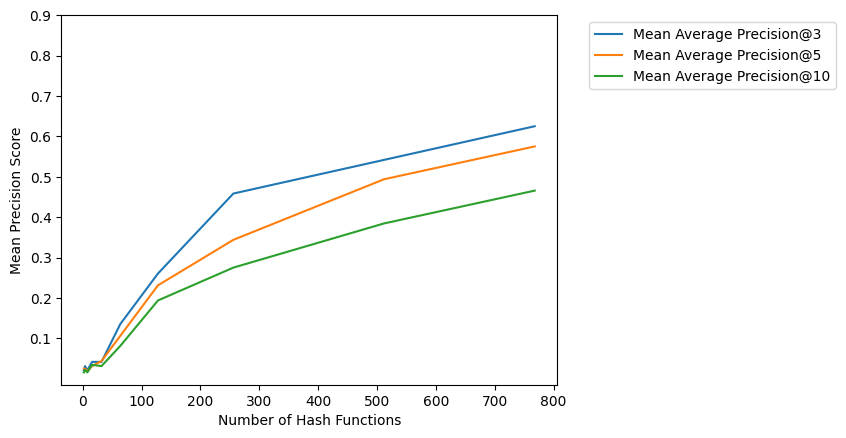

In [68]:
plt.plot(nbits_config, mean_precision_score_at_3, label="Mean Average Precision@3")
plt.plot(nbits_config, mean_precision_score_at_5, label="Mean Average Precision@5")
plt.plot(nbits_config, mean_precision_score_at_10, label="Mean Average Precision@10")

plt.xlabel("Number of Hash Functions")
plt.ylabel("Mean Precision Score")

plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.yticks(np.arange(0.1, 1, 0.1))
plt.show()

### Mean Reciprocal Rank@K

In [25]:
def get_reciprocal_rank(most_relevant_document, predictions):
    try:
        rank = predictions.index(most_relevant_document) + 1
        return 1.0 / rank
    except ValueError:
        return 0.0

In [41]:
def get_mean_reciprocal_rank(k):
    mean_reciprocal_ranks = []
    for nbits  in nbits_config:
        df = load_parquet(os.path.join(output_folder_path, f"starbucks_lsh__embedding=bge_mode=lsh_similarity_nbits={nbits}.parquet"))
        reciprocal_rank = 0
        for i in range(num_questions):
            question = ground_truth["question"][i]
            most_relevant_document = ground_truth["top_k"][i][1]
            predictions = remove_query_from_predictions(list(json.loads(df["top_k"][i])["Review"].values()), question)[0:k]
            reciprocal_rank += get_reciprocal_rank(most_relevant_document, predictions)
        mean_reciprocal_ranks.append(reciprocal_rank/num_questions)
    return mean_reciprocal_ranks
            

In [49]:
mean_reciprocal_ranks_at_1 = get_mean_reciprocal_rank(1)
mean_reciprocal_ranks_at_3 = get_mean_reciprocal_rank(3)
mean_reciprocal_ranks_at_5 = get_mean_reciprocal_rank(5)
mean_reciprocal_ranks_at_10 = get_mean_reciprocal_rank(10)

In [50]:
df = pd.DataFrame({
    'nbits_config': nbits_config,
    'Mean Reciprocal Rank@1': mean_reciprocal_ranks_at_1,
    'Mean Reciprocal Rank@3': mean_reciprocal_ranks_at_3,
    'Mean Reciprocal Rank@5': mean_reciprocal_ranks_at_5,
    'Mean Reciprocal Rank@10': mean_reciprocal_ranks_at_10
})
df

,nbits_config,Mean Reciprocal Rank@1,Mean Reciprocal Rank@3,Mean Reciprocal Rank@5,Mean Reciprocal Rank@10
0,2,0.00000,0.000000,0.000000,0.000000
1,4,0.03125,0.031250,0.031250,0.031250
2,8,0.03125,0.031250,0.031250,0.031250
3,16,0.03125,0.031250,0.031250,0.031250
4,32,0.03125,0.031250,0.053125,0.056250
5,64,0.03125,0.031250,0.031250,0.039583
6,128,0.25000,0.265625,0.287500,0.302381
7,256,0.21875,0.260417,0.274479,0.304638
8,512,0.21875,0.302083,0.333333,0.348090
9,768,0.28125,0.354167,0.397917,0.422173


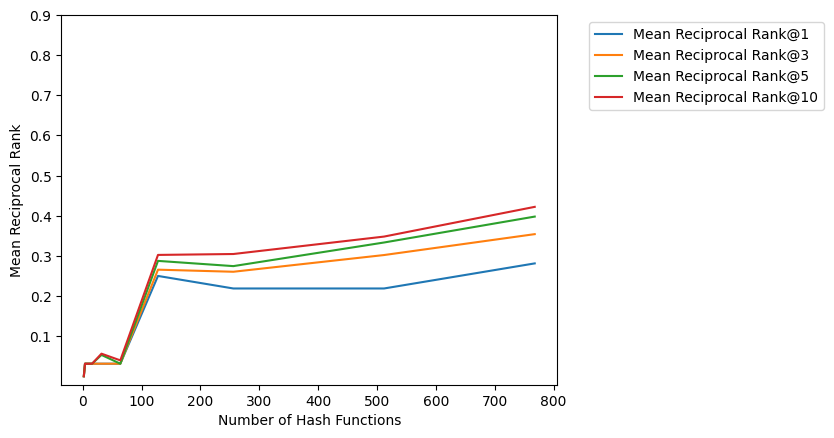

In [52]:
plt.plot(nbits_config, mean_reciprocal_ranks_at_1, label="Mean Reciprocal Rank@1")
plt.plot(nbits_config, mean_reciprocal_ranks_at_3, label="Mean Reciprocal Rank@3")
plt.plot(nbits_config, mean_reciprocal_ranks_at_5, label="Mean Reciprocal Rank@5")
plt.plot(nbits_config, mean_reciprocal_ranks_at_10, label="Mean Reciprocal Rank@10")

plt.xlabel("Number of Hash Functions")
plt.ylabel("Mean Reciprocal Rank")

plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.yticks(np.arange(0.1, 1, 0.1))
plt.show()

### Mean Normalised Discounted Cumulative Rank@K

In [115]:
def compute_relevance_scores(ground_truth, predictions):
    relevance_map = {doc: len(ground_truth) - score for score, doc in enumerate(ground_truth)}
    scores = [relevance_map.get(doc, 0) for doc in predictions]
    return scores


In [116]:
def get_mean_ndcg_k(k):
    mean_ndcgs = []
    for nbits in nbits_config:
        df = load_parquet(os.path.join(output_folder_path, f"starbucks_lsh__embedding=bge_mode=lsh_similarity_nbits={nbits}.parquet"))
        ndcg = 0
        for i in range(num_questions):
            question = ground_truth["question"][i]
            relevance_score = compute_relevance_scores(ground_truth["top_k"][i][1:k+1], remove_query_from_predictions(list(json.loads(df["top_k"][i])["Review"].values()), question)[0:k])
            true_relevance = list(range(k,0,-1)) 
            idcg = 0
            dcg = 0
            for i in range(len(relevance_score)):
                # formula
                idcg += true_relevance[i] / math.log(i+2,2)
                dcg += relevance_score[i] / math.log(i+2,2)
            ndcg += dcg/idcg
        mean_ndcgs.append(ndcg/num_questions)
    return mean_ndcgs


In [117]:
mean_normalised_dcgs_at_3 = get_mean_ndcg_k(3)
mean_normalised_dcgs_at_5 = get_mean_ndcg_k(5)
mean_normalised_dcgs_at_10 = get_mean_ndcg_k(10)

In [119]:
df = pd.DataFrame({
    'nbits_config': nbits_config,
    'Mean Normalised Discounted Cumulative Rank@3': mean_normalised_dcgs_at_3,
    'Mean Normalised Discounted Cumulative Rank@5': mean_normalised_dcgs_at_5,
    'Mean Normalised Discounted Cumulative Rank@10': mean_normalised_dcgs_at_10
})
df

,nbits_config,Mean Normalised Discounted Cumulative Rank@3,Mean Normalised Discounted Cumulative Rank@5,Mean Normalised Discounted Cumulative Rank@10
0,2,0.000000,0.000000,0.008328
1,4,0.013984,0.010147,0.015212
2,8,0.013984,0.012809,0.015186
3,16,0.013984,0.011324,0.024748
4,32,0.013984,0.033317,0.032526
5,64,0.041953,0.054828,0.079197
6,128,0.207032,0.212556,0.235813
7,256,0.237578,0.251729,0.337104
8,512,0.296094,0.340971,0.428870
9,768,0.380703,0.454937,0.525557
